In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CIFAR-10 데이터 로드 및 전처리
def load_and_preprocess_data():
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

    # 데이터 정규화 (0~255 범위의 값을 0~1로 변환)
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # 레이블을 one-hot 인코딩
    y_train = utils.to_categorical(y_train, 10)
    y_test = utils.to_categorical(y_test, 10)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_and_preprocess_data()

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10) (10000, 10)


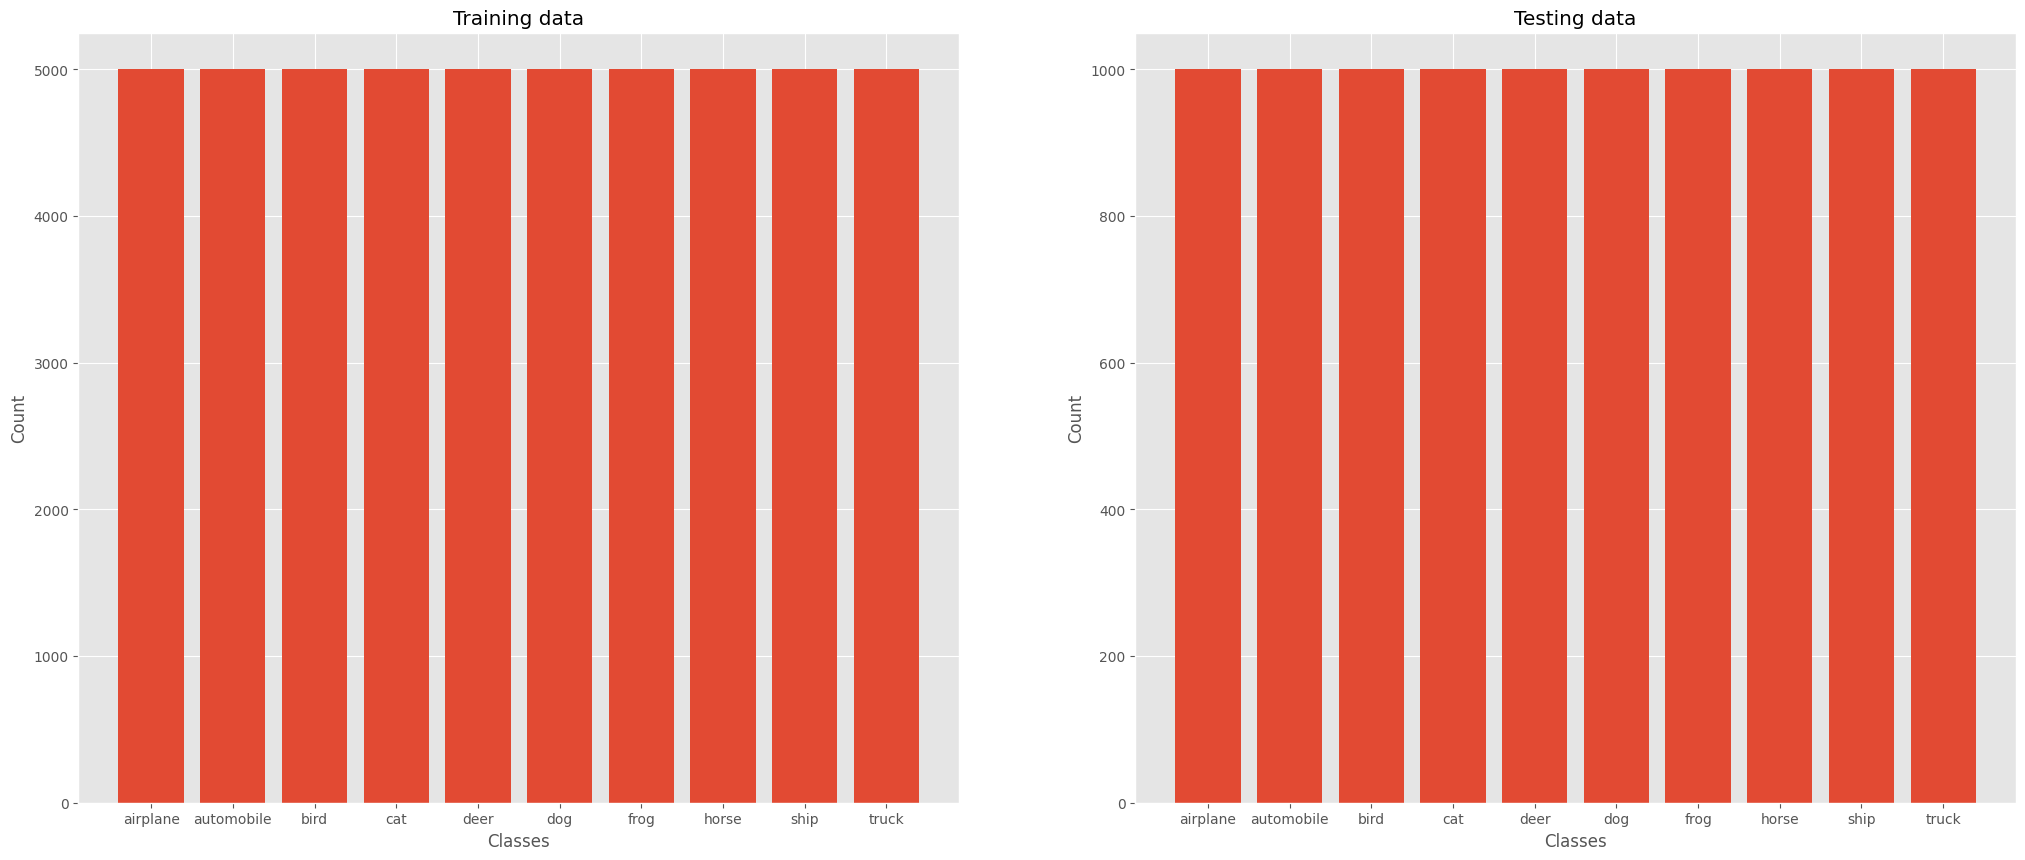

In [3]:
plt.style.use('ggplot')

classes = ('airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')

# np.argmax로 원래 클래스 레이블을 찾음
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# 각 클래스별로 빈도를 계산
train_class_counts = np.bincount(y_train_labels, minlength=10)
test_class_counts = np.bincount(y_test_labels, minlength=10)

fig, axs = plt.subplots(1, 2, figsize=(25, 10))

# 훈련 정답 데이터 (5000 * 10 = 50000)
axs[0].bar(classes, train_class_counts)
axs[0].set_title('Training data')
axs[0].set_xlabel('Classes')
axs[0].set_ylabel('Count')

# 테스트 정답 데이터 (1000 * 10 = 10000)
axs[1].bar(classes, test_class_counts)
axs[1].set_title('Testing data')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Count')

plt.show()

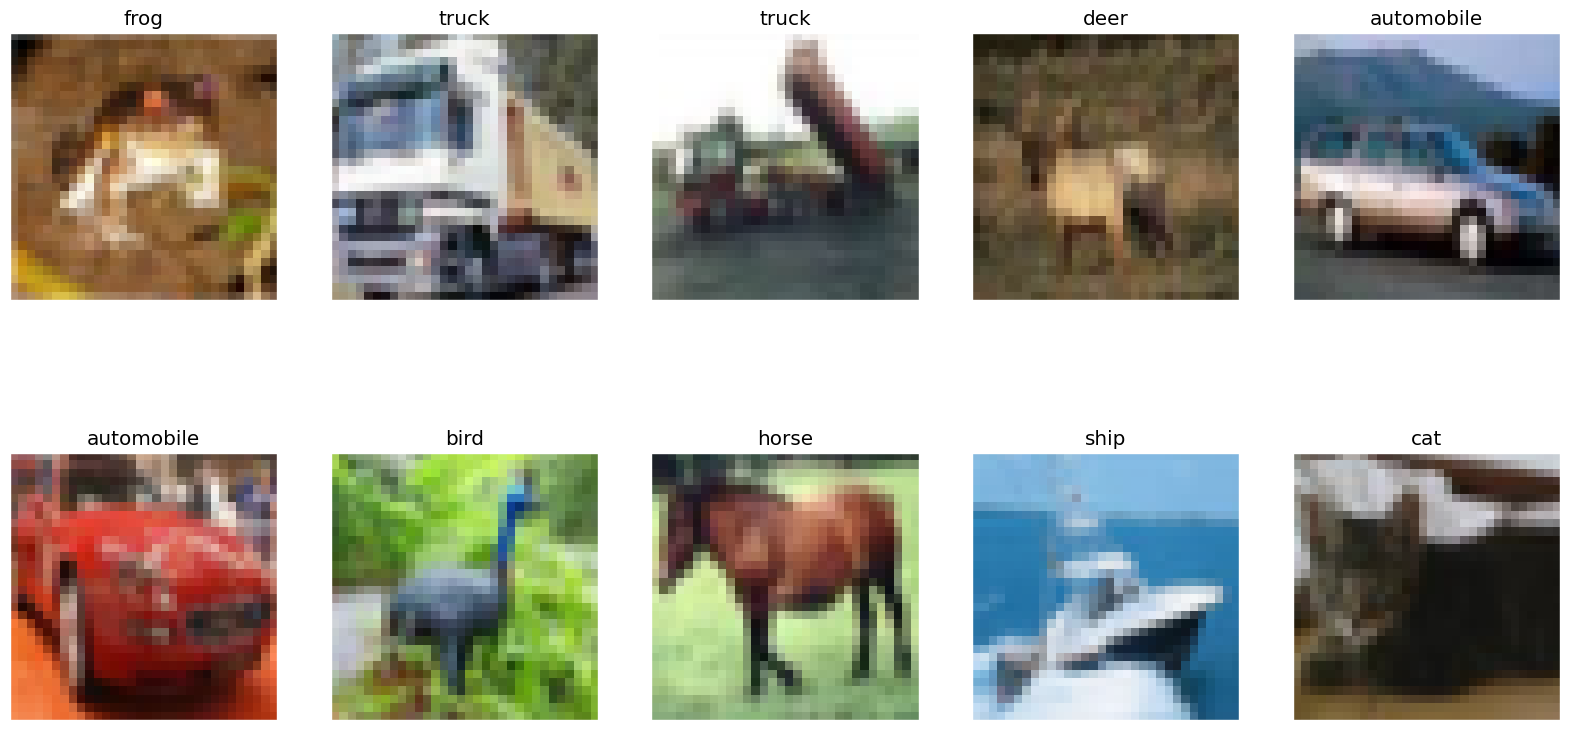

In [4]:
# 앞 10개의 이미지 확인

fig = plt.figure(figsize=(20, 10))

for i in np.arange(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])

    plt.imshow(x_train[i])
    ax.set_title(classes[np.argmax(y_train[i])])

In [5]:
# ResNet-18

# Residual Block 정의
def residual_block(x, filters, stride=1):
    shortcut = x

    # 첫 번째 Conv 레이어
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 Conv 레이어
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # 스킵 연결 (입력과 출력의 차원이 다를 경우 Conv 추가)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # 스킵 연결 더하기
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ResNet-18 모델 정의
def ResNet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # 초기 Conv 레이어
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = layers.Dropout(0.5)(x)

    # 출력층
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # 모델 생성
    model = models.Model(inputs, outputs)
    return model

# 데이터 증강을 위한 ImageDataGenerator 설정
datagen = ImageDataGenerator(
    rotation_range=15,     # 이미지를 최대 15도 회전
    width_shift_range=0.1, # 이미지를 가로 방향으로 최대 10% 이동
    height_shift_range=0.1,# 이미지를 세로 방향으로 최대 10% 이동
    horizontal_flip=True,  # 이미지를 수평 방향으로 뒤집기 (좌우 뒤집기)
)

# 모델 학습 및 평가
def train_and_evaluate():
    # ResNet-18 모델 생성
    model = ResNet18(input_shape=(32, 32, 3), num_classes=10)

    # 모델 컴파일
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early Stopping 설정 (검증 손실이 5 에폭 동안 개선되지 않으면 학습 중단)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 모델 학습
    history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                        epochs=50,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping])

    # 모델 평가
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test accuracy: {test_acc}")

    return model, history

# 모델 학습 및 평가 실행
model, history = train_and_evaluate()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 94ms/step - accuracy: 0.3940 - loss: 1.7201 - val_accuracy: 0.4876 - val_loss: 1.8657
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.6491 - loss: 0.9875 - val_accuracy: 0.6420 - val_loss: 1.1550
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.7314 - loss: 0.7710 - val_accuracy: 0.7144 - val_loss: 0.8309
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.7717 - loss: 0.6546 - val_accuracy: 0.7159 - val_loss: 0.8612
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.7979 - loss: 0.5896 - val_accuracy: 0.6973 - val_loss: 1.0446
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.8203 - loss: 0.5183 - val_accuracy: 0.7843 - val_loss: 0.6541
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.8341 - loss: 0.4800 - val_accuracy: 0.7708 - val_loss: 0.7085
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.8468 - loss: 0.4436 - val_accura

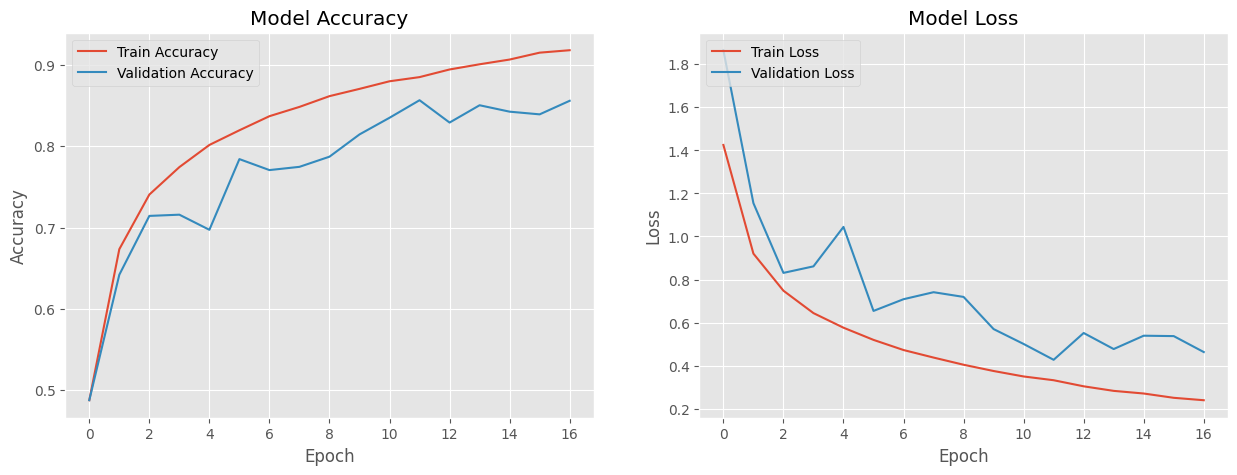

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# 정확도 그래프
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

# 손실 그래프
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

plt.show()